## L5 - 1: Regression Model with TF DenseFeatures

### Instructions
- Build regression model to predict resting blood pressure (trestbps field in the dataset) using Tensorflow DenseFeatures
- Please include the age and sex features and create a TF cross feature(https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column) with them by binning the age field 
- Evaluate with common regression(MSE, MAE) and classification metrics(accuracy, F1, precision and recall across classes, AUC). No ROC or PR curve needed since this is a regression model that was converted to have a binary output and does not have the confidence in a given prediction.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
#from https://archive.ics.uci.edu/ml/datasets/Heart+Disease
swiss_dataset_path = "./data/heart_disease_data/processed_swiss.csv"
swiss_df = pd.read_csv(swiss_dataset_path).replace('?', np.nan)

In [2]:
column_list = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num_label']

In [3]:
cleveland_df = pd.read_csv("./data/heart_disease_data/processed.cleveland.txt",  names=column_list).replace('?', np.nan)

In [4]:
combined_heart_df = pd.concat([swiss_df, cleveland_df])

In [5]:
len(combined_heart_df)

426

### Solution
- Note that the dataset has only a three features and for the solution provided this does not include other important features that you can use to augment model performance. 

In [6]:
selected_features = ['sex',  'age', 'trestbps', 'thalach' ]
bp_df = combined_heart_df[selected_features].replace({1:"male", 0:"female"})

In [7]:
# how many rows with at least a single null value
sum(bp_df.apply(lambda x: sum(x.isnull().values), axis = 1)>0)

2

In [8]:
len(bp_df[bp_df['trestbps'].isnull()==True])

2

In [9]:
bp_df.head()

,sex,age,trestbps,thalach
0,male,32.0,95,127
1,male,34.0,115,154
2,male,35.0,NaN,130
3,male,36.0,110,125
4,female,38.0,105,166


In [10]:
#for simplicity will drop rows with null since predictor is null
clean_df = bp_df.dropna()

In [11]:
clean_df.head()

,sex,age,trestbps,thalach
0,male,32.0,95,127
1,male,34.0,115,154
3,male,36.0,110,125
4,female,38.0,105,166
5,female,38.0,110,156


In [12]:
clean_df['trestbps'] = clean_df['trestbps'].astype(float)
clean_df['thalach'] = clean_df['thalach'].astype(float)

/var/folders/sy/nnrjh0cx1897yr6m0_fq9wmc0000gq/T/ipykernel_41606/2110516164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['trestbps'] = clean_df['trestbps'].astype(float)
/var/folders/sy/nnrjh0cx1897yr6m0_fq9wmc0000gq/T/ipykernel_41606/2110516164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['thalach'] = clean_df['thalach'].astype(float)


In [13]:
#adapted from https://www.tensorflow.org/tutorials/structured_data/feature_columns
def df_to_dataset(df, predictor,  batch_size=32):
    df = df.copy()
    labels = df.pop(predictor)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [14]:
#split 80 20 train test split - not ideal
train_dataset = clean_df.sample(frac=0.8,random_state=0)
test_dataset = clean_df.drop(train_dataset.index)

In [15]:
PREDICTOR_FIELD = 'trestbps'
batch_size = 128
train_ds = df_to_dataset(train_dataset, PREDICTOR_FIELD, batch_size=batch_size)
test_ds = df_to_dataset(test_dataset, PREDICTOR_FIELD, batch_size=batch_size)

In [16]:
train_ds

<_BatchDataset element_spec=({'sex': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'age': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'thalach': TensorSpec(shape=(None,), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [17]:
# create TF numeric feature
tf_numeric_age_feature = tf.feature_column.numeric_column(key='age', default_value=0, dtype=tf.float64)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [18]:
b_list = [ 0, 18, 25, 40, 55, 65, 80, 100]
#create TF bucket feature from numeric feature
tf_numeric_age_feature
tf_bucket_age_feature = tf.feature_column.bucketized_column(source_column=tf_numeric_age_feature, boundaries= b_list)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [19]:
#using list b/c small number of unique values
gender_vocab = tf.feature_column.categorical_column_with_vocabulary_list(
      'sex', bp_df['sex'].unique())
gender_one_hot = tf.feature_column.indicator_column(gender_vocab)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [20]:
# add cross features - use example from TF
crossed_age_gender_feature = tf.feature_column.crossed_column([tf_bucket_age_feature, gender_vocab], hash_bucket_size=1000)
tf_crossed_age_gender_feature = tf.feature_column.indicator_column(crossed_age_gender_feature)

Instructions for updating:
Use `tf.keras.layers.experimental.preprocessing.HashedCrossing` instead for feature crossing when preprocessing data to train a Keras model.


In [21]:
feature_columns = [ tf_crossed_age_gender_feature, tf_bucket_age_feature, gender_one_hot ]
dense_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'DenseFeatures'

In [22]:
# Use same architecture as example
def build_model(dense_feature_layer):
  model = tf.keras.Sequential([
    dense_feature_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [23]:
model = build_model(dense_feature_layer)

NameError: name 'dense_feature_layer' is not defined

In [ ]:
EPOCHS = 1000
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=50)
history = model.fit(train_ds,   callbacks=[early_stop], epochs=EPOCHS,  verbose=1)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Train for 3 steps
Epoch 1/1000
3/3 [==============================] - 1s 481ms/step - loss: 17558.0907 - mae: 131.0745 - mse: 17545.7910
Epoch 2/1000
3/3 [==============================] - 0s 16ms/step - loss: 17595.1989 - mae: 130.9139 - mse: 17503.6777
Epoch 3/1000
3/3 [==============================] - 0s 17ms/step - loss: 17435.2409 - mae: 130.7810 - mse: 17468.9766
Epoch 4/1000
3/3 [==============================] - 0s 14ms/step - loss: 17398.4541 - mae: 130.6364 - mse: 17431.0430
Epoch 5/1000
3/3 [==============================] - 0s 18ms/step - loss: 17378.1065 - mae: 130.4600 - mse: 17384.9160
Epoch 6/1000
3/3 [=

3/3 [==============================] - 0s 18ms/step - loss: 338.5269 - mae: 14.1843 - mse: 328.6629
Epoch 131/1000
3/3 [==============================] - 0s 17ms/step - loss: 329.8115 - mae: 14.2248 - mse: 330.4391
Epoch 132/1000
3/3 [==============================] - 0s 20ms/step - loss: 331.7769 - mae: 14.2252 - mse: 329.5286
Epoch 133/1000
3/3 [==============================] - 0s 19ms/step - loss: 338.2256 - mae: 14.2257 - mse: 331.9612
Epoch 134/1000
3/3 [==============================] - 0s 17ms/step - loss: 334.1363 - mae: 14.3272 - mse: 333.0421
Epoch 135/1000
3/3 [==============================] - 0s 19ms/step - loss: 325.8714 - mae: 14.1532 - mse: 328.8834
Epoch 136/1000
3/3 [==============================] - 0s 17ms/step - loss: 330.9637 - mae: 14.2340 - mse: 331.1554
Epoch 137/1000
3/3 [==============================] - 0s 19ms/step - loss: 337.7814 - mae: 14.3264 - mse: 331.9425
Epoch 138/1000
3/3 [==============================] - 0s 19ms/step - loss: 321.2529 - mae: 14.1

In [24]:
loss, mae, mse = model.evaluate(test_ds, verbose=2)
print("MAE:{}\nMSE:{}".format(mae, mse))

NameError: name 'model' is not defined

In [25]:
test_labels = test_dataset[PREDICTOR_FIELD].values

In [38]:
test_predictions = model.predict(test_ds).flatten()

In [39]:
model_pred_outputs = {
    "pred": test_predictions,
    "actual_value": test_labels,
}
model_output_df = pd.DataFrame(model_pred_outputs)

In [40]:
# Convert Regression Output to binary classification output
model_output_df.tail()

,pred,actual_value
41,135.608017,134.0
42,140.288422,170.0
43,135.608017,125.0
44,132.475433,120.0
45,125.253456,130.0


In [ ]:
#convert to binary prediction for Brier score - resting bps above 130
def convert_to_binary(df, pred_field, actual_field):
    # score is the field name we will use for predictions and is what Aequitas uses
    df['score'] = df[pred_field].apply(lambda x: 1 if x>=130 else 0 )
    # label_value is the field name we will use for the truth value and is what Aequitas uses
    df['label_value'] = df[actual_field].apply(lambda x: 1 if x>=130 else 0)
    return df

In [42]:
binary_df = convert_to_binary(model_output_df, 'pred', 'actual_value')
binary_df.head()

,pred,actual_value,score,label_value
0,135.608017,95.0,1,0
1,126.332336,115.0,0,0
2,125.253456,170.0,0,1
3,140.288422,160.0,1,1
4,139.055923,140.0,1,1


In [43]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

In [ ]:
y_true = binary_df['label_value'].values
y_pred = binary_df['score'].values

In [45]:
accuracy_score(y_true, y_pred)

0.5869565217391305

In [46]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.47      0.49        19
           1       0.64      0.67      0.65        27

    accuracy                           0.59        46
   macro avg       0.57      0.57      0.57        46
weighted avg       0.58      0.59      0.59        46



In [47]:
roc_auc_score(y_true, y_pred)

0.5701754385964912

## L5 - 2: Demographic Bias Analysis

### Instructions
- Using the Compas dataset prepared by Aequitas, perform a Fairness Disparity Analysis on the under 25 Asian female reference group. See the documentation for reference -https://github.com/dssg/aequitas. In particular focus your analysis on fairness and disparity for FPR and where applicable try to leverage some of the visualizations Aequitas provides.

### Aequitas Compas Dataset
- Using 2016 dataset from ProPublica for automated criminal risk assessment algorithms and adapted from Aequitas notebook - https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb
- Preprocessed using this script --https://github.com/dssg/aequitas/blob/master/examples/compas_data_for_aequitas.py

The Aequitas Bias() class is used to calculate disparities between groups based on the crosstab returned by the Group() class get_crosstabs() method we used for preprocessing the dataset. 

### Instructions from Aequitas on Calculating Disparities across Reference Groups
(adapted from https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb)

Disparities are calculated as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$

Below, we use get_disparity_predefined_groups() which allows us to choose reference groups that clarify the output for the practitioner.

The Aequitas Bias() class includes two additional get disparity functions: get_disparity_major_group() and get_disparity_min_metric(), which automate base group selection based on sample majority (across each attribute) and minimum value for each calculated bias metric, respectively.

The get_disparity_predefined_groups() allows user to define a base group for each attribute.

Disparities Calculated Calcuated:
- True Positive Rate Disparity	'tpr_disprity'
- True Negative Rate	'tnr_disparity'
- False Omission Rate	'for_disparity'
- False Discovery Rate	'fdr_disparity'
- False Positive Rate	'fpr_disparity'
- False NegativeRate	'fnr_disparity'
- Negative Predictive Value	'npv_disparity'
- Precision Disparity	'precision_disparity'
- Predicted Positive Ratio$_k$ Disparity	'ppr_disparity'
- Predicted Positive Ratio$_g$ Disparity	'pprev_disparity'

**How do I interpret calculated disparity ratios?**
The calculated disparities from the dataframe returned by the Bias() class get_disparity_ methods are in relation to a reference group, which will always have a disparity of 1.0.

The differences in False Positive Rates, noted in the discussion of the Group() class above, are clarified using the disparity ratio (fpr_disparity). Black people are falsely identified as being high or medium risks 1.9 times the rate for white people.

As seen above, False Discovery Rates have much less disparity (fdr_disparity), or fraction of false postives over predicted positive in a group. As reference groups have disparity = 1 by design in Aequitas, the lower disparity is highlighted by the fdr_disparity value close to 1.0 (0.906) for the race attribute group 'African-American' when disparities are calculated using predefined base group 'Caucasian'. Note that COMPAS is calibrated to balance False Positive Rate and False Discovery Rates across groups.


**How does the selected reference group affect disparity calculations?**
Disparities calculated in the the Aequitas Bias() class based on the crosstab returned by the Group() class get_crosstabs() method can be derived using several different base gorups. In addition to using user-specified groups illustrated above, Aequitas can automate base group selection based on dataset characterisitcs:

Evaluating disparities calculated in relation to a different 'race' reference group
Changing even one attribute in the predefined groups will alter calculated disparities. When a different pre-defined group 'Hispanic' is used, we can see that Black people are 2.1 times more likely to be falsely identified as being high or medium risks as Hispanic people are (compared to 1.9 times more likely than white people), and even less likely to be falsely identified as low risk when compared to Hispanic people rather than white people.

In [ ]:
# Use Aequitas Data that was transformed
compas_df = pd.read_csv("./data/compas_for_aequitas.csv")

In [49]:
compas_df.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


### Solution

### Dataset Preparation

In [50]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = compas_df[['sex', 'age_cat', 'race', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [3317]}


### Summarized Metric View

In [51]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,3317,sex,Female,591,804,288,195,609,303,498,897,1395,7214
1,1,binary 0/1,3317,sex,Male,2726,3093,994,1021,2072,1732,2753,3066,5819,7214
2,1,binary 0/1,3317,age_cat,25 - 45,1924,2185,741,706,1479,1183,1889,2220,4109,7214
3,1,binary 0/1,3317,age_cat,Greater than 45,394,1182,181,285,897,213,498,1078,1576,7214
4,1,binary 0/1,3317,age_cat,Less than 25,999,530,360,225,305,639,864,665,1529,7214
5,1,binary 0/1,3317,race,African-American,2174,1522,805,532,990,1369,1901,1795,3696,7214
6,1,binary 0/1,3317,race,Asian,8,24,2,3,21,6,9,23,32,7214
7,1,binary 0/1,3317,race,Caucasian,854,1600,349,461,1139,505,966,1488,2454,7214
8,1,binary 0/1,3317,race,Hispanic,190,447,87,129,318,103,232,405,637,7214
9,1,binary 0/1,3317,race,Native American,12,6,3,1,5,9,10,8,18,7214


In [52]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,Female,0.61,0.68,0.24,0.49,0.32,0.39,0.76,0.51,0.18,0.42,0.36
1,sex,Male,0.63,0.68,0.33,0.36,0.32,0.37,0.67,0.64,0.82,0.47,0.47
2,age_cat,25 - 45,0.63,0.67,0.32,0.39,0.33,0.37,0.68,0.61,0.58,0.47,0.46
3,age_cat,Greater than 45,0.43,0.83,0.24,0.46,0.17,0.57,0.76,0.54,0.12,0.25,0.32
4,age_cat,Less than 25,0.74,0.46,0.42,0.36,0.54,0.26,0.58,0.64,0.30,0.65,0.57
5,race,African-American,0.72,0.55,0.35,0.37,0.45,0.28,0.65,0.63,0.66,0.59,0.51
6,race,Asian,0.67,0.91,0.12,0.25,0.09,0.33,0.88,0.75,0.00,0.25,0.28
7,race,Caucasian,0.52,0.77,0.29,0.41,0.23,0.48,0.71,0.59,0.26,0.35,0.39
8,race,Hispanic,0.44,0.79,0.29,0.46,0.21,0.56,0.71,0.54,0.06,0.30,0.36
9,race,Native American,0.90,0.62,0.17,0.25,0.38,0.10,0.83,0.75,0.00,0.67,0.56


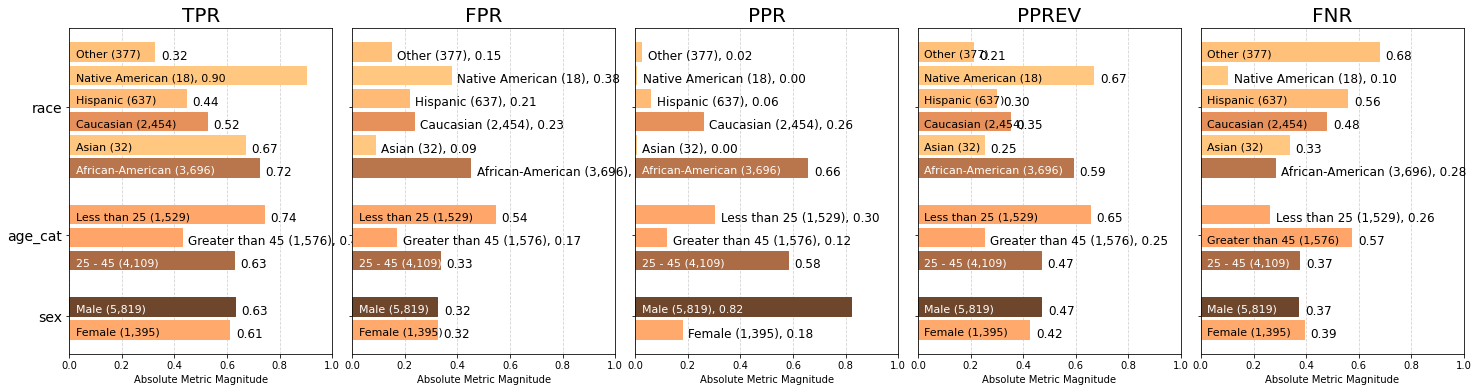

In [53]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)

### Add Reference Group

In [ ]:
bdf = b.get_disparity_predefined_groups(clean_xtab,
                    original_df=ae_df,
                    ref_groups_dict={'race':'Asian', 'sex':'Female', 'age_cat':'Less than 25'},
                    alpha=0.05,
                    check_significance=False)

f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


### FPR Analysis

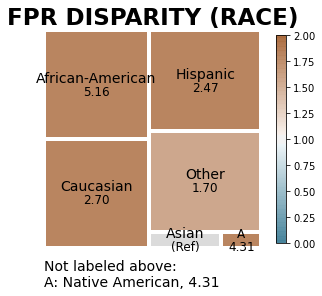

In [ ]:
 fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity',
                                       attribute_name='race')

African Americans are over 5x more likely to be falsely identified as well as Hispanic and Caucasian have over 2x more likely to be falsely identified than Asian.

### Absolute Value Fairness Determination
- Red = False/Not Fair
- Green = True/Fair

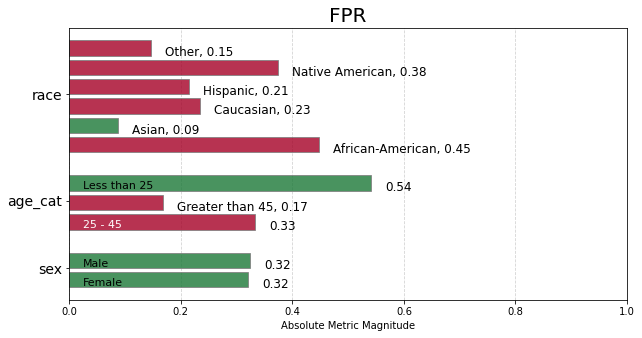

In [56]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

## L5 - 3: Uncertainty Estimation Model

### Instructions
- Given the Swiss heart disease dataset we have been working with, create an uncertainty estimation model that accounts for Epistemic Uncertainty as well. Provide the mean and standard deviation outputs.
- https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html

In [57]:
import tensorflow_probability as tfp

In [ ]:
'''
Adapted from Tensorflow Probability Regression tutorial  https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb
'''
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2*n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
            tfp.distributions.Normal(loc=t[..., :n],
                                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])


def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
            tfp.distributions.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])


In [ ]:
def build_seq_prob_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
           tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                            scale=1e-3 + tf.math.softplus(0.1 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_prob_model(train_ds,   feature_layer,  epochs=5, loss_metric='mse'):
    model = build_seq_prob_model(feature_layer)
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    loss = negloglik
    model.compile(optimizer='adam', loss=loss, metrics=[loss_metric])
    history = model.fit(train_ds,
                        epochs=epochs)
    return model, history

In [ ]:
prob_model, history = build_prob_model(train_ds, dense_feature_layer,  epochs=1000)

Train for 3 steps
Epoch 1/1000
3/3 [==============================] - 2s 732ms/step - loss: 19461.4526 - mse: 17542.1484
Epoch 2/1000
3/3 [==============================] - 0s 19ms/step - loss: 20273.1341 - mse: 17612.1797
Epoch 3/1000
3/3 [==============================] - 0s 17ms/step - loss: 19040.5793 - mse: 17508.7031
Epoch 4/1000
3/3 [==============================] - 0s 19ms/step - loss: 17696.3185 - mse: 17345.2695
Epoch 5/1000
3/3 [==============================] - 0s 20ms/step - loss: 17654.7524 - mse: 17587.3047
Epoch 6/1000
3/3 [==============================] - 0s 22ms/step - loss: 20322.9690 - mse: 17677.1602
Epoch 7/1000
3/3 [==============================] - 0s 20ms/step - loss: 17600.8288 - mse: 17688.5859
Epoch 8/1000
3/3 [==============================] - 0s 18ms/step - loss: 17702.6468 - mse: 17290.7930
Epoch 9/1000
3/3 [==============================] - 0s 21ms/step - loss: 22503.5057 - mse: 17557.4922
Epoch 10/1000
3/3 [==============================] - 0s 23ms/st

In [ ]:
feature_list = ['sex', 'age', 'thalach']
x_tst = dict(test_dataset[feature_list])
yhat = prob_model(x_tst)
prob_preds = prob_model.predict(test_ds)
m = yhat.mean()
s = yhat.stddev()

In [ ]:
prob_outputs = {
    "pred": prob_preds.flatten(),
     "actual_value": test_dataset['trestbps'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [ ]:
prob_output_df.head()

In [ ]:
yhats = [prob_model(x_tst) for _ in range(10)]

In [ ]:
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    print("Mean distributions sampled:{}".format(m))
    print("Standard deviation distributions sampled:{}".format(s))
